In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transactions = pd.read_parquet('/content/drive/My Drive/transaction_fraud_data.parquet')
currency_rates = pd.read_parquet('/content/drive/My Drive/historical_currency_exchange.parquet')

In [4]:
print("Размеры данных:")
print(f"Транзакции: {transactions.shape}")
print(f"Курсы валют: {currency_rates.shape}\n")

Размеры данных:
Транзакции: (7483766, 23)
Курсы валют: (31, 12)



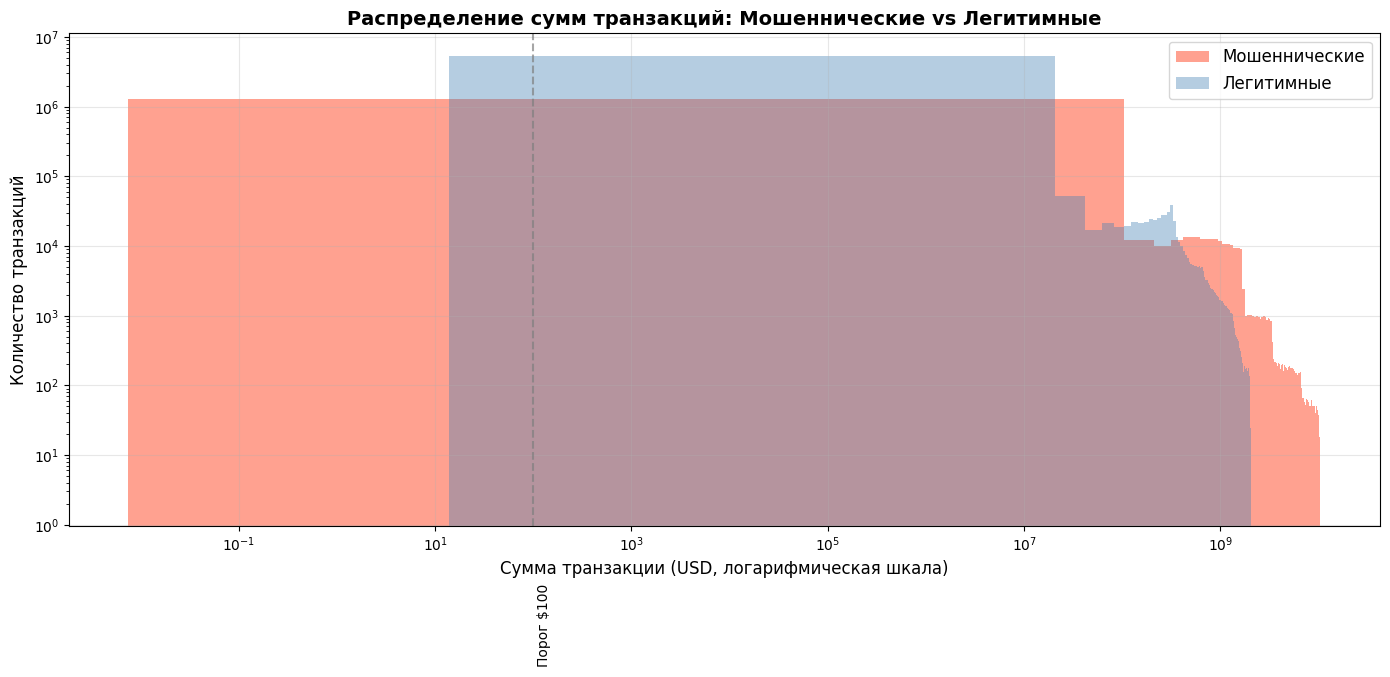

In [5]:
exchange_long = currency_rates.melt(
    id_vars=['date'],
    var_name='currency_code',
    value_name='exchange_rate'
)

transactions['date'] = transactions['timestamp'].dt.date
exchange_long['date'] = pd.to_datetime(exchange_long['date']).dt.date

merged = pd.merge(
    transactions,
    exchange_long,
    left_on=['date', 'currency'],
    right_on=['date', 'currency_code'],
    how='left'
)

missing = merged['exchange_rate'].isna().sum()
if missing > 0:
    print(f"Внимание: {missing} транзакций не имеют обменного курса. Они будут исключены.")
    merged = merged.dropna(subset=['exchange_rate'])

merged['amount_usd'] = merged['amount'] * merged['exchange_rate']

fraud = merged[merged['is_fraud']]
non_fraud = merged[~merged['is_fraud']]

plt.figure(figsize=(14, 7))
plt.hist(
    fraud['amount_usd'],
    bins=100,
    alpha=0.6,
    label='Мошеннические',
    color='tomato',
    log=True
)
plt.hist(
    non_fraud['amount_usd'],
    bins=100,
    alpha=0.4,
    label='Легитимные',
    color='steelblue',
    log=True
)

plt.xscale('log')
plt.xlabel('Сумма транзакции (USD, логарифмическая шкала)', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.title('Распределение сумм транзакций: Мошеннические vs Легитимные', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.axvline(x=100, color='gray', linestyle='--', alpha=0.7)
plt.text(110, 0.01, 'Порог $100', rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

Доля мошеннических транзакций: 19.97%


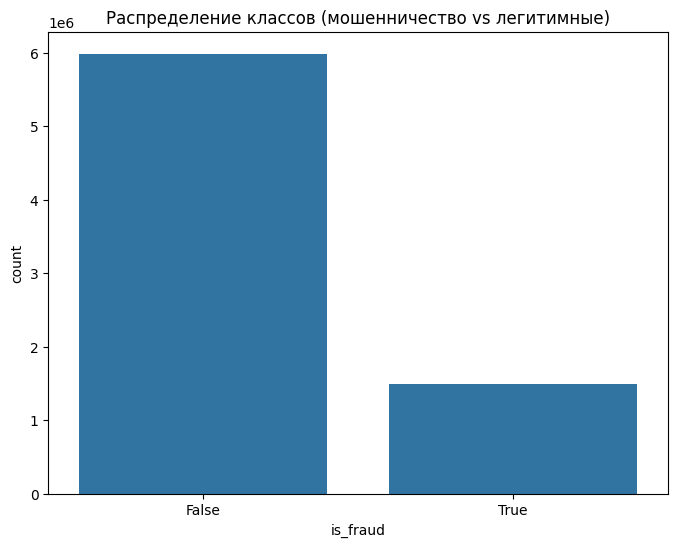

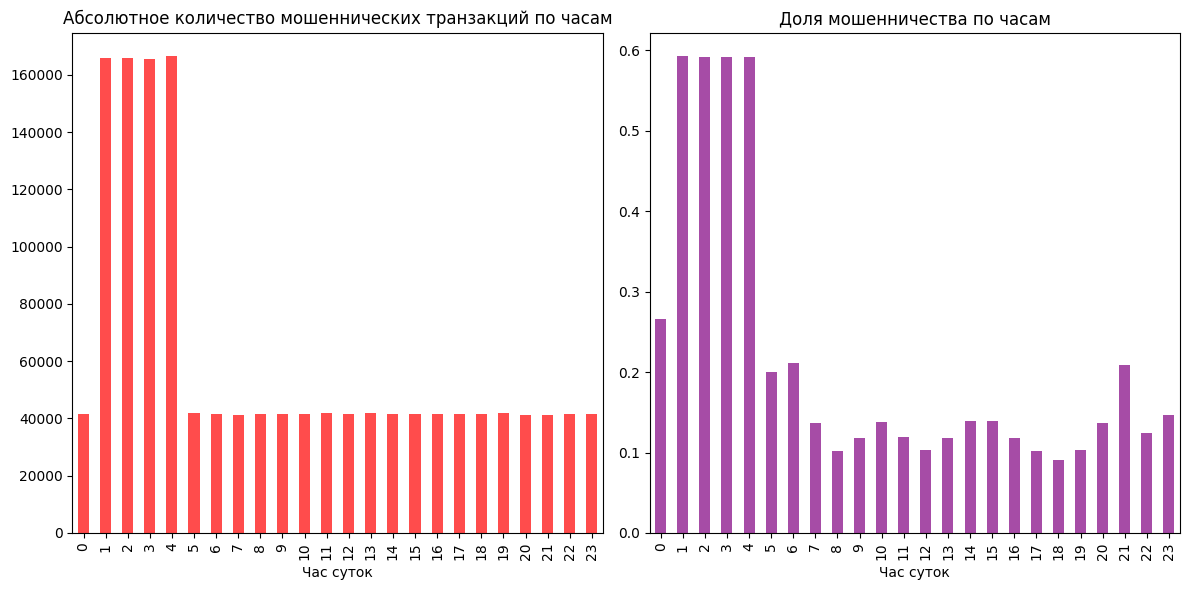

In [6]:
fraud_ratio = transactions['is_fraud'].mean()
print(f"Доля мошеннических транзакций: {fraud_ratio:.2%}")

plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=transactions)
plt.title('Распределение классов (мошенничество vs легитимные)')
plt.show()

transactions['hour'] = transactions['timestamp'].dt.hour

fraud_by_hour = transactions.groupby(['hour', 'is_fraud']).size().unstack()
fraud_by_hour['ratio'] = fraud_by_hour[True] / (fraud_by_hour[True] + fraud_by_hour[False])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fraud_by_hour[True].plot(kind='bar', color='red', alpha=0.7)
plt.title('Абсолютное количество мошеннических транзакций по часам')
plt.xlabel('Час суток')

plt.subplot(1, 2, 2)
fraud_by_hour['ratio'].plot(kind='bar', color='purple', alpha=0.7)
plt.title('Доля мошенничества по часам')
plt.xlabel('Час суток')
plt.tight_layout()
plt.show()

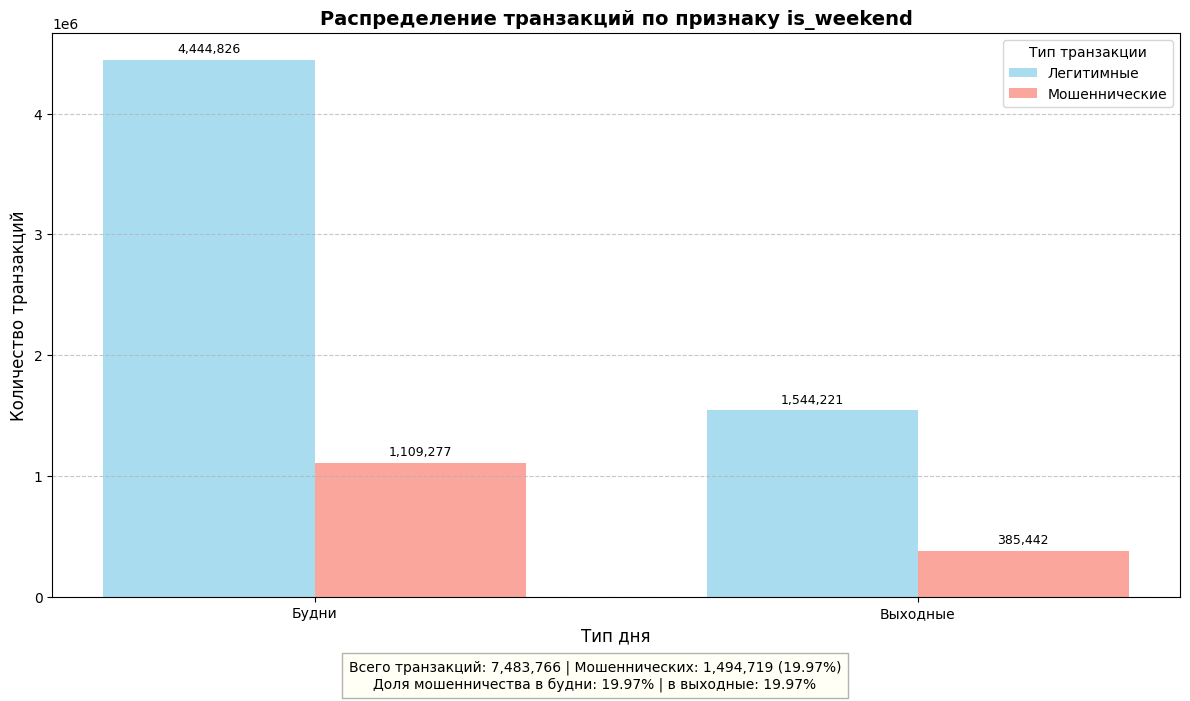

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

counts = pd.crosstab(
    index=transactions['is_weekend'],
    columns=transactions['is_fraud'],
    margins=True,
    margins_name="Всего"
)

counts = counts.rename(index={False: 'Будни', True: 'Выходные'})
counts = counts.rename(columns={False: 'Легитимные', True: 'Мошеннические'})

x = np.arange(len(counts.index) - 1)
width = 0.35

plt.figure(figsize=(12, 7))
ax = plt.subplot()
legit_bars = ax.bar(
    x - width/2,
    counts.loc[['Будни', 'Выходные'], 'Легитимные'],
    width,
    label='Легитимные',
    alpha=0.7,
    color='skyblue'
)
fraud_bars = ax.bar(
    x + width/2,
    counts.loc[['Будни', 'Выходные'], 'Мошеннические'],
    width,
    label='Мошеннические',
    alpha=0.7,
    color='salmon'
)

ax.set_xlabel('Тип дня', fontsize=12)
ax.set_ylabel('Количество транзакций', fontsize=12)
ax.set_title('Распределение транзакций по признаку is_weekend', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Будни', 'Выходные'])
ax.legend(title='Тип транзакции', fontsize=10)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

add_labels(legit_bars)
add_labels(fraud_bars)

total_transactions = counts.loc['Всего', 'Легитимные'] + counts.loc['Всего', 'Мошеннические']
fraud_percent = (counts.loc['Всего', 'Мошеннические'] / total_transactions) * 100
fraud_weekday_percent = (counts.loc['Будни', 'Мошеннические'] / counts.loc['Будни', 'Всего']) * 100
fraud_weekend_percent = (counts.loc['Выходные', 'Мошеннические'] / counts.loc['Выходные', 'Всего']) * 100

stats_text = (
    f"Всего транзакций: {total_transactions:,} | Мошеннических: {counts.loc['Всего', 'Мошеннические']:,} ({fraud_percent:.2f}%)\n"
    f"Доля мошенничества в будни: {fraud_weekday_percent:.2f}% | в выходные: {fraud_weekend_percent:.2f}%"
)
plt.figtext(0.5, 0.01, stats_text,
            ha="center",
            fontsize=10,
            bbox={"facecolor": "lightyellow", "alpha": 0.3, "pad": 5})

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.05, 1, 1])

/tmp/ipython-input-8-2506763223.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(
/tmp/ipython-input-8-2506763223.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


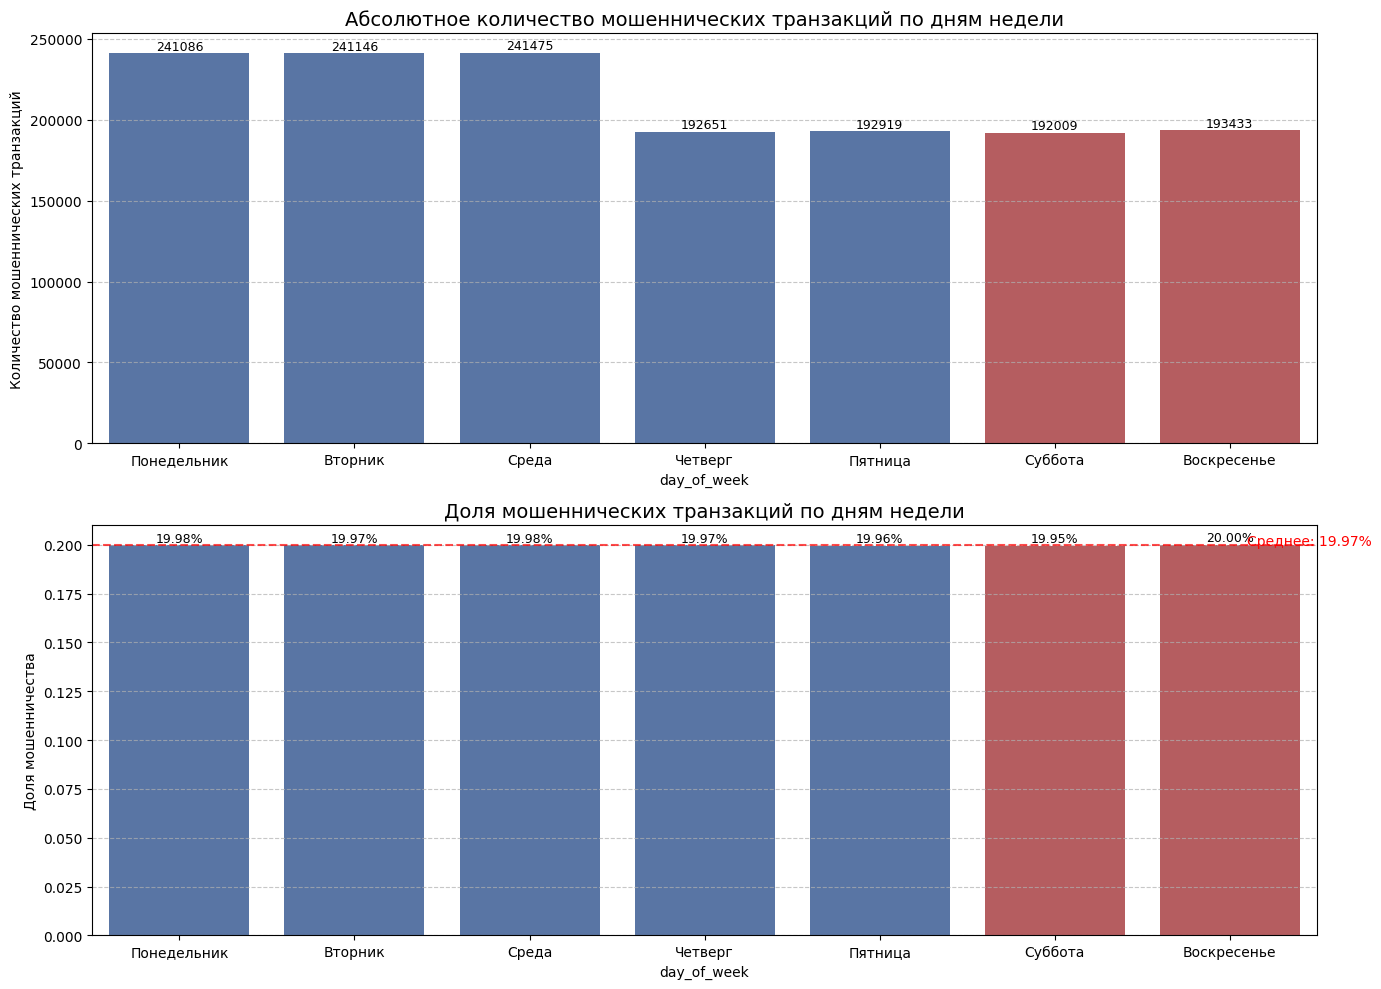

In [8]:
transactions['day_of_week'] = transactions['timestamp'].dt.dayofweek

days = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

fraud_by_day = transactions.groupby('day_of_week')['is_fraud'].agg(['sum', 'count', 'mean'])
fraud_by_day = fraud_by_day.rename(columns={'mean': 'fraud_ratio', 'sum': 'fraud_count', 'count': 'total_transactions'})
fraud_by_day.index = fraud_by_day.index.map(days)

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
ax1 = sns.barplot(
    x=fraud_by_day.index,
    y=fraud_by_day['fraud_count'],
    palette=['#4c72b0' if day not in ['Суббота', 'Воскресенье'] else '#c44e52' for day in fraud_by_day.index]
)
plt.title('Абсолютное количество мошеннических транзакций по дням недели', fontsize=14)
plt.ylabel('Количество мошеннических транзакций')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax1.patches:
    ax1.annotate(f"{int(p.get_height())}",
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points',
                 fontsize=9)

plt.subplot(2, 1, 2)
ax2 = sns.barplot(
    x=fraud_by_day.index,
    y=fraud_by_day['fraud_ratio'],
    palette=['#4c72b0' if day not in ['Суббота', 'Воскресенье'] else '#c44e52' for day in fraud_by_day.index]
)
plt.title('Доля мошеннических транзакций по дням недели', fontsize=14)
plt.ylabel('Доля мошенничества')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f"{height:.2%}",
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points',
                 fontsize=9)

avg_fraud = transactions['is_fraud'].mean()
plt.axhline(y=avg_fraud, color='r', linestyle='--', alpha=0.7)
plt.text(6.1, avg_fraud, f'Среднее: {avg_fraud:.2%}', color='r')

plt.tight_layout()
plt.show()

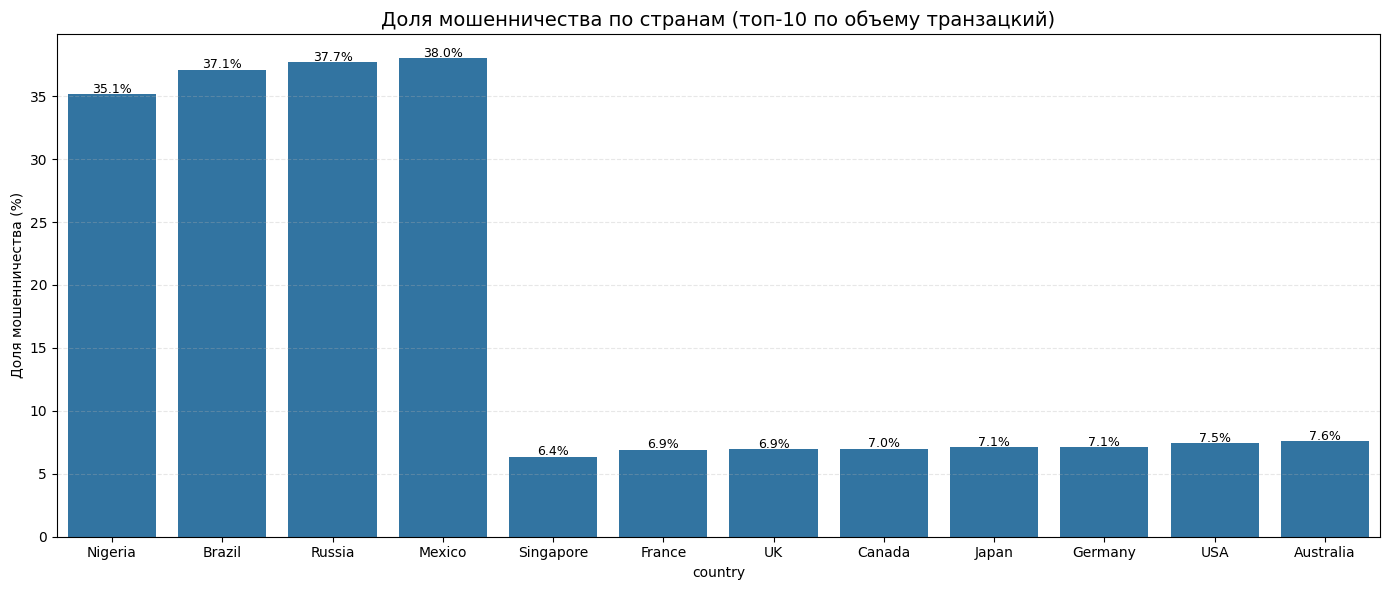

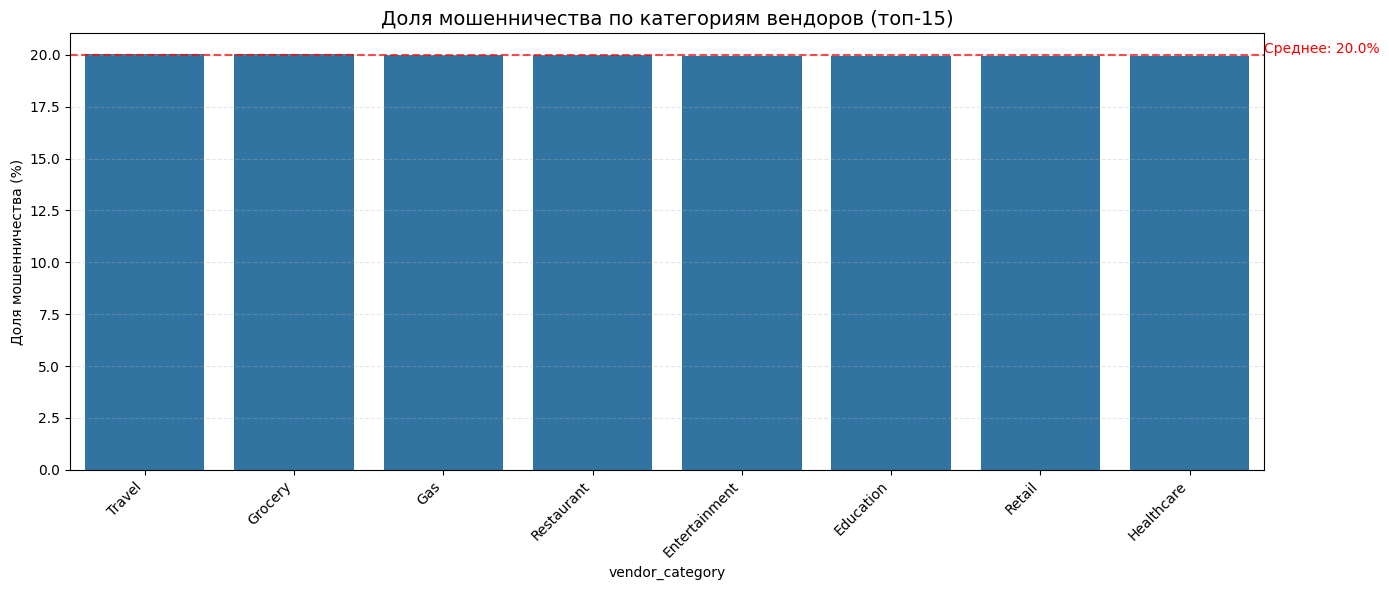

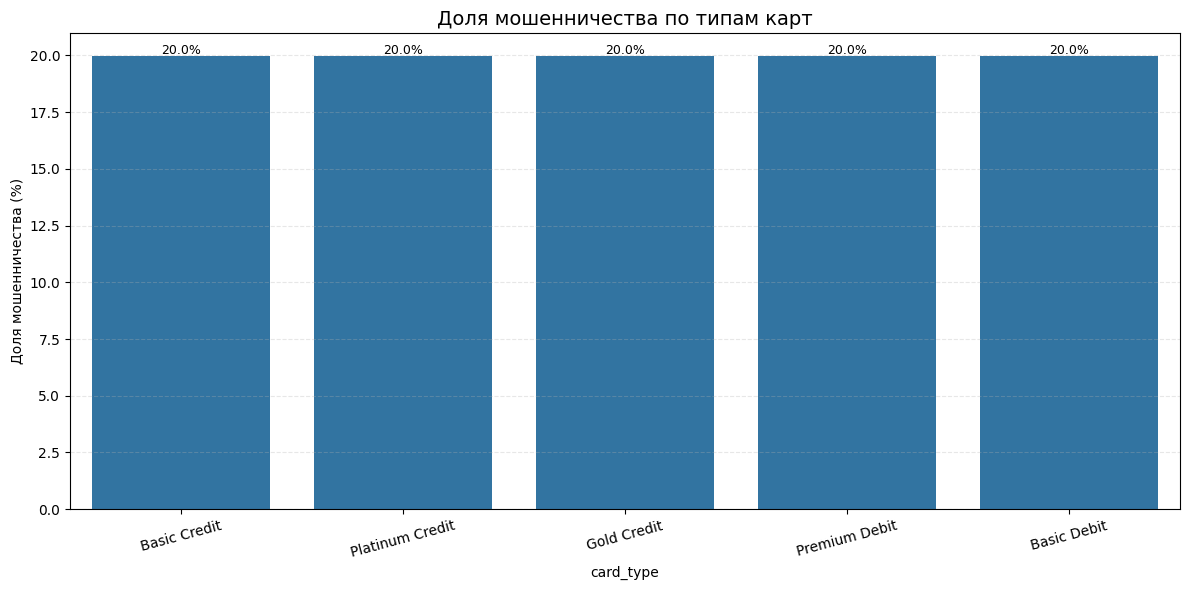

In [5]:
top_countries = transactions['country'].value_counts().head(20).index
country_fraud = transactions[transactions['country'].isin(top_countries)]

plt.figure(figsize=(14, 6))
fraud_ratio = country_fraud.groupby('country')['is_fraud'].mean() * 100
fraud_ratio = fraud_ratio.reindex(top_countries)

sns.barplot(
  x=fraud_ratio.index,
  y=fraud_ratio.values,
)

plt.title('Доля мошенничества по странам (топ-10 по объему транзацкий)', fontsize=14)
plt.ylabel('Доля мошенничества (%)')
plt.xticks(rotation=0)

for i, v in enumerate(fraud_ratio.values):
  plt.text(i, v + 0.1, f"{v:.1f}%", ha='center', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
fraud_ratio = transactions.groupby('vendor_category')['is_fraud'].mean().sort_values(ascending=False) * 100
fraud_ratio = fraud_ratio.head(15)

sns.barplot(
      x=fraud_ratio.index,
      y=fraud_ratio.values,
)
plt.title('Доля мошенничества по категориям вендоров (топ-15)', fontsize=14)
plt.ylabel('Доля мошенничества (%)')
plt.xticks(rotation=45, ha='right')

avg_fraud = transactions['is_fraud'].mean() * 100
plt.axhline(y=avg_fraud, color='r', linestyle='--', alpha=0.7)
plt.text(len(fraud_ratio)-0.5, avg_fraud+0.1, f'Среднее: {avg_fraud:.1f}%', color='r')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
fraud_ratio = transactions.groupby('card_type')['is_fraud'].mean().sort_values(ascending=False) * 100

main_cards = fraud_ratio.head(8).index
fraud_ratio = fraud_ratio[main_cards]

sns.barplot(
    x=fraud_ratio.index,
    y=fraud_ratio.values,
)

plt.title('Доля мошенничества по типам карт', fontsize=14)
plt.ylabel('Доля мошенничества (%)')
plt.xticks(rotation=15)

for i, v in enumerate(fraud_ratio.values):
    plt.text(i, v + 0.1, f"{v:.1f}%", ha='center', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-6-1733586335.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=x, y=y, data=data, ax=ax,
/tmp/ipython-input-6-1733586335.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=x, y=y, data=data, ax=ax,
/tmp/ipython-input-6-1733586335.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=x, y=y, data=data, ax=ax,
/tmp/ipython-input-6-1733586335.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

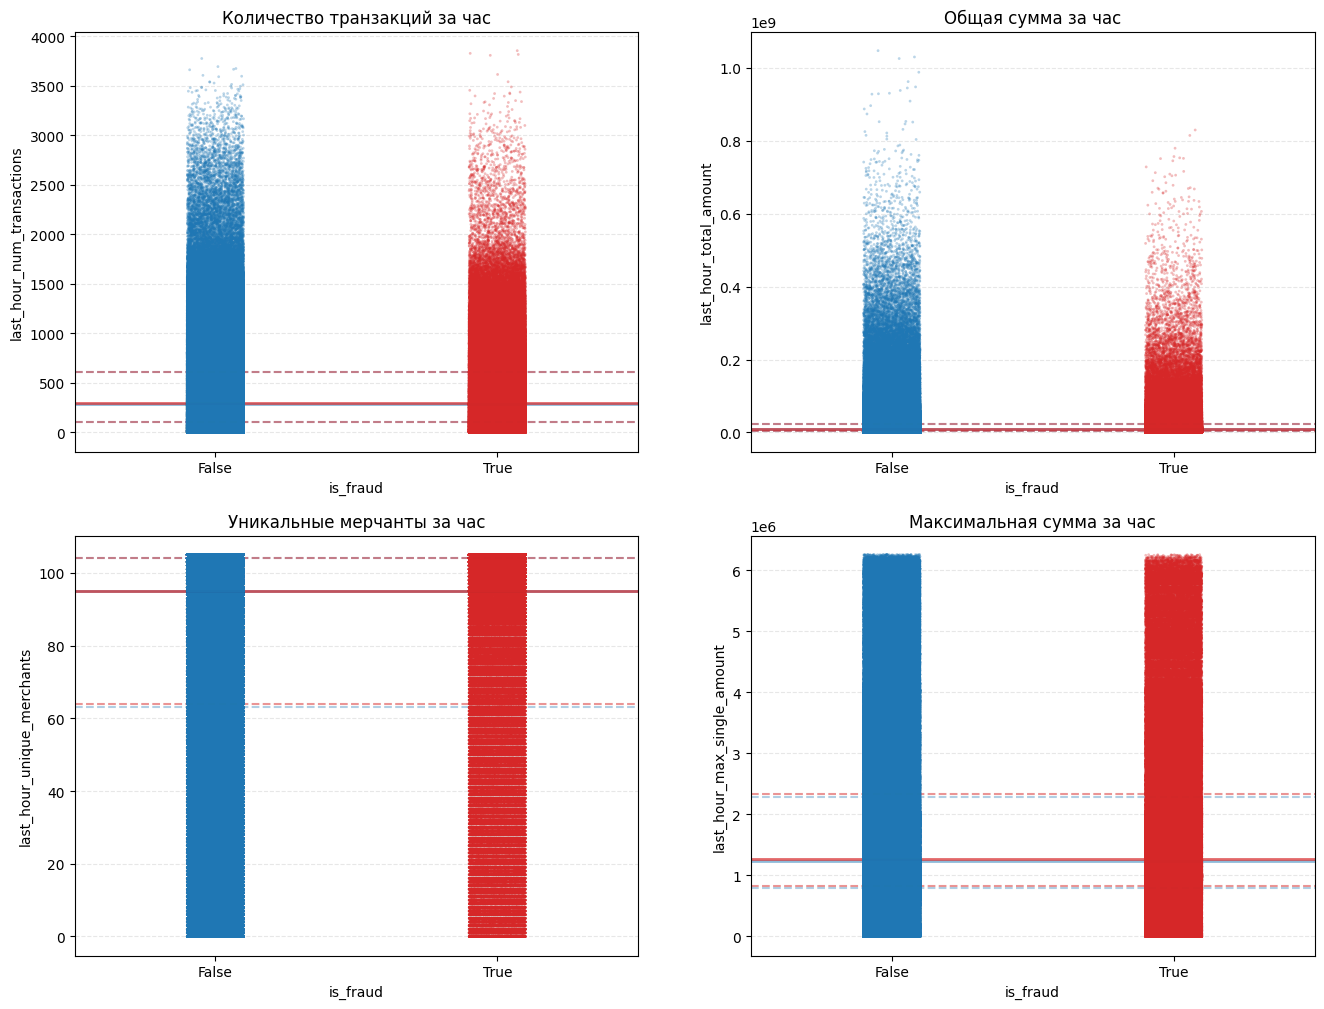

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

VIZ_SAMPLE_SIZE = 0.2
RANDOM_STATE = 42


viz_sample = transactions.sample(frac=VIZ_SAMPLE_SIZE, random_state=RANDOM_STATE)

start_unpack = time.time()
unpacked_data = {
      'last_hour_num_transactions': [x['num_transactions'] for x in viz_sample['last_hour_activity']],
      'last_hour_total_amount': [x['total_amount'] for x in viz_sample['last_hour_activity']],
      'last_hour_unique_merchants': [x['unique_merchants'] for x in viz_sample['last_hour_activity']],
      'last_hour_max_single_amount': [x['max_single_amount'] for x in viz_sample['last_hour_activity']],
      'is_fraud': viz_sample['is_fraud'].values,
      'amount': viz_sample['amount'].values
}
plot_data = pd.DataFrame(unpacked_data)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

def fast_box_stripplot(x, y, data, ax, title):
      sns.stripplot(x=x, y=y, data=data, ax=ax,
                    alpha=0.3, jitter=True, size=2, palette=['#1f77b4', '#d62728'])

      for is_fraud in [False, True]:
          subset = data[data[x] == is_fraud][y]
          if len(subset) > 0:
              color = '#d62728' if is_fraud else '#1f77b4'
              alpha = 0.7 if is_fraud else 0.5

              ax.axhline(np.median(subset), color=color, linestyle='-', alpha=alpha, linewidth=2)
              ax.axhline(np.percentile(subset, 25), color=color, linestyle='--', alpha=alpha*0.7)
              ax.axhline(np.percentile(subset, 75), color=color, linestyle='--', alpha=alpha*0.7)

      ax.set_title(title)
      ax.grid(axis='y', linestyle='--', alpha=0.3)

fast_box_stripplot('is_fraud', 'last_hour_num_transactions', plot_data,
                  axes[0, 0], 'Количество транзакций за час')
fast_box_stripplot('is_fraud', 'last_hour_total_amount', plot_data,
                  axes[0, 1], 'Общая сумма за час')
fast_box_stripplot('is_fraud', 'last_hour_unique_merchants', plot_data,
                  axes[1, 0], 'Уникальные мерчанты за час')
fast_box_stripplot('is_fraud', 'last_hour_max_single_amount', plot_data,
                  axes[1, 1], 'Максимальная сумма за час')

In [7]:
VIZ_SAMPLE_SIZE = 0.05
RANDOM_STATE = 42

viz_sample = transactions.sample(frac=VIZ_SAMPLE_SIZE, random_state=RANDOM_STATE)

Доля мошенничества вне страны проживания:
is_outside_home_country
False    0.024902
True     0.567753
Name: is_fraud, dtype: float64


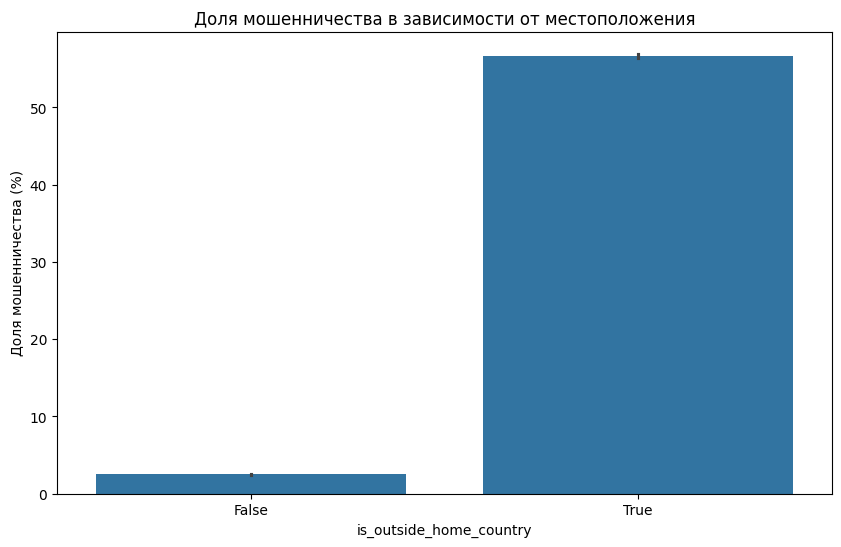

In [8]:
from scipy import stats

outside_home = transactions.groupby('is_outside_home_country')['is_fraud'].mean()
print("Доля мошенничества вне страны проживания:")
print(outside_home)

plt.figure(figsize=(10, 6))
sns.barplot(x='is_outside_home_country', y='is_fraud', data=viz_sample,
            estimator=lambda x: sum(x)/len(x)*100)
plt.title('Доля мошенничества в зависимости от местоположения')
plt.ylabel('Доля мошенничества (%)')
plt.show()

Доля мошенничества по рисковым категориям:
is_high_risk_vendor
False    0.199642
True     0.199986
Name: is_fraud, dtype: float64


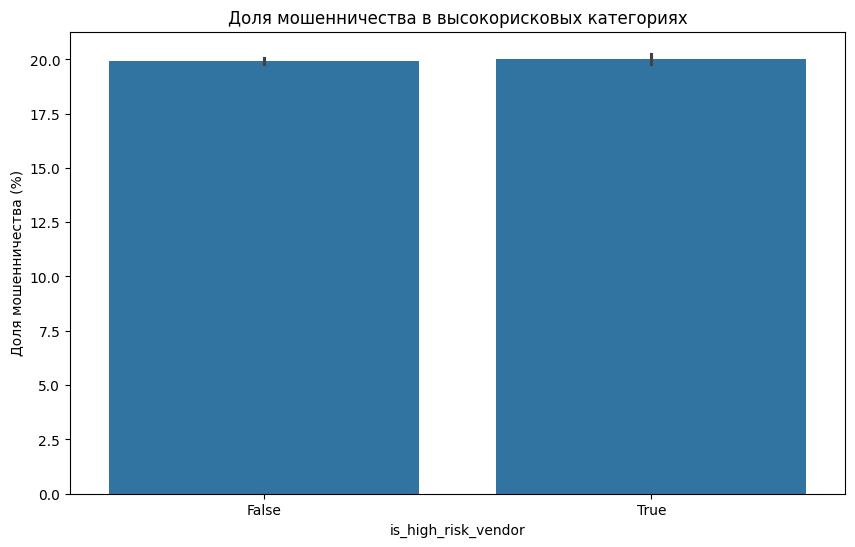

In [9]:
risk_comparison = transactions.groupby('is_high_risk_vendor')['is_fraud'].mean()
print("Доля мошенничества по рисковым категориям:")
print(risk_comparison)

plt.figure(figsize=(10, 6))
sns.barplot(x='is_high_risk_vendor', y='is_fraud', data=viz_sample,
            estimator=lambda x: sum(x)/len(x)*100)
plt.title('Доля мошенничества в высокорисковых категориях')
plt.ylabel('Доля мошенничества (%)')
plt.show()

Доля мошенничества по признаку присутствия карты:
is_card_present
False    0.123475
True     1.000000
Name: is_fraud, dtype: float64


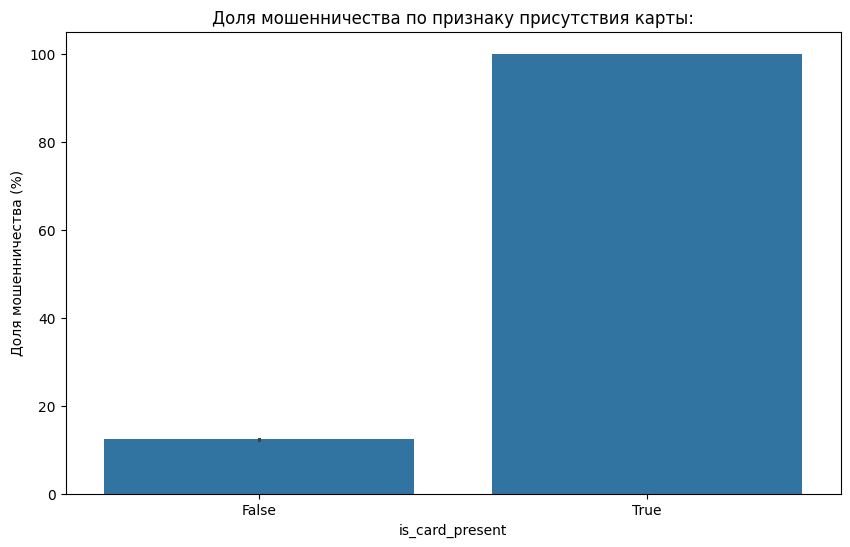

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

card_present_comparison = transactions.groupby('is_card_present')['is_fraud'].mean()
print("Доля мошенничества по признаку присутствия карты:")
print(card_present_comparison)

plt.figure(figsize=(10, 6))
sns.barplot(x='is_card_present', y='is_fraud', data=viz_sample,
            estimator=lambda x: sum(x)/len(x)*100)
plt.title('Доля мошенничества по признаку присутствия карты:')
plt.ylabel('Доля мошенничества (%)')
plt.show()

Доля мошенничества по признаку канала проведения транзакции:
channel
mobile    0.123878
pos       1.000000
web       0.123275
Name: is_fraud, dtype: float64


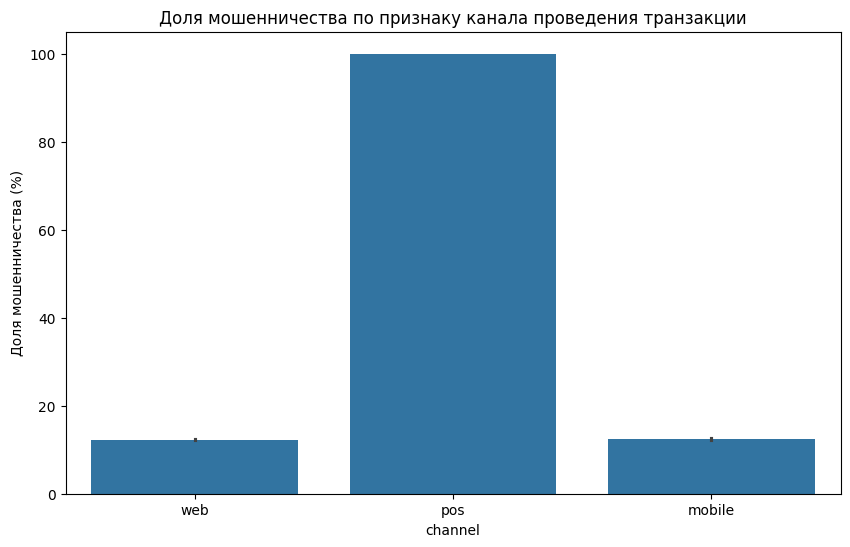

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

channel_comparison = transactions.groupby('channel')['is_fraud'].mean()
print("Доля мошенничества по признаку канала проведения транзакции:")
print(channel_comparison)

plt.figure(figsize=(10, 6))
sns.barplot(x='channel', y='is_fraud', data=viz_sample,
            estimator=lambda x: sum(x)/len(x)*100)
plt.title('Доля мошенничества по признаку канала проведения транзакции')
plt.ylabel('Доля мошенничества (%)')
plt.show()

In [12]:
top_devices = transactions['device'].value_counts().head(20).index

device_fraud = transactions[transactions['device'].isin(top_devices)]
device_fraud = device_fraud.groupby('device')['is_fraud'].mean().sort_values(ascending=False) * 100

print("Доля мошенничества по устройствам:")
for device, fraud_ratio in device_fraud.items():
    print(f"{device}: {fraud_ratio:.2f}%")

Доля мошенничества по устройствам:
Chip Reader: 100.00%
NFC Payment: 100.00%
Magnetic Stripe: 100.00%
Firefox: 12.68%
Safari: 12.62%
Android App: 12.51%
Chrome: 12.37%
iOS App: 12.27%
Edge: 11.68%
